In [1]:
import uuid

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [13]:
import geoopt
import torch
import torch.nn as nn
import torch.nn.functional as F
from geoopt.optim import RiemannianAdam
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torch.utils.data import DataLoader, Dataset

In [4]:
from src.dataset import PariwiseDataset
from src.losses import *
from src.models import *
from src.trainer import MetricTrainer
from src.utils import *

# manual run

In [5]:
version: Literal["100k", "1m"] = "100k"
data = load_movielens(version)
data_train, data_valid, data_test = train_test_split_interations(data, method="last")

N_USERS = data.user_id.nunique()
N_ITEMS = data.item_id.nunique()
user_sizes = data.groupby("user_id").count().item_id.to_numpy()
item_sizes = data.groupby("item_id").count().user_id.to_numpy()

In [6]:
cfg = {}
cfg["bs"] = 512
cfg["lr"] = 1e-3
cfg["neg_samples"] = 10
cfg["embedding_dim"] = 256
cfg["margin"] = 0.5
cfg["lam"] = 1
cfg["step_size"] = 10
cfg["max_norm"] = 1
cfg["drop_rate"] = 0
cfg["weighted"] = False

In [8]:
train_set = PariwiseDataset(
    data_train,
    N_USERS,
    N_ITEMS,
    neg_samples=cfg["neg_samples"],
    weights=(item_sizes if cfg["weighted"] else None),
)

valid_set = PariwiseDataset(data_valid, N_USERS, N_ITEMS, neg_samples=100)
test_set = PariwiseDataset(data_test, N_USERS, N_ITEMS, neg_samples=100)

train_loader = DataLoader(train_set, batch_size=cfg["bs"], shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_set, batch_size=N_USERS, shuffle=False)
test_loader = DataLoader(test_set, batch_size=N_USERS, shuffle=False)

In [10]:
model = "HyperCML"
name = str(uuid.uuid4())
print(name)

20bfb03a-4c5a-4fd9-b8b9-c4e770c50954


In [11]:
if model == "CML":
    metric_model = CML(
        N_USERS,
        N_ITEMS,
        embedding_dim=cfg["embedding_dim"],
        dropout_rate=cfg["drop_rate"],
        max_norm=cfg["max_norm"],
    )
    metric_criterion = AdditiveLoss(
        nn.TripletMarginLoss(margin=cfg["margin"]),
        CovarianceLoss(),
        coefficients=(1, cfg["lam"]),
    )

    metric_trainer = MetricTrainer(metric_model, metric_criterion)
    metric_trainer.optimizer = Adam(metric_trainer.model.parameters(), lr=cfg["lr"])

elif model == "HyperCML":
    manifold = geoopt.PoincareBall(c=1, learnable=True)
    metric_model = HyperCML(
        N_USERS,
        N_ITEMS,
        embedding_dim=cfg["embedding_dim"],
        dropout_rate=cfg["drop_rate"],
        manifold=manifold,
        max_norm=cfg["max_norm"],
    )
    metric_criterion = AdditiveLoss(
        nn.TripletMarginWithDistanceLoss(
            margin=cfg["margin"], distance_function=manifold.dist
        ),
        DistortionLoss(manifold=manifold),
        coefficients=(1, cfg["lam"]),
    )

    metric_trainer = MetricTrainer(metric_model, metric_criterion)
    metric_trainer.optimizer = RiemannianAdam(
        metric_trainer.model.parameters(), lr=cfg["lr"]
    )

In [12]:
metric_trainer.fit(train_loader, test_loader, epochs=50, plot=False, validate_every=50)
torch.save(trainer.model, f"logs/{name}.pt")

  0%|          | 0/50 [00:00<?, ?it/s]

epoch: 1


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.4556912717719874
--------------------------------------------------------------------------------
epoch: 2


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.3779513873159885
--------------------------------------------------------------------------------
epoch: 3


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.303929549952348
--------------------------------------------------------------------------------
epoch: 4


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.2552767197291055
--------------------------------------------------------------------------------
epoch: 5


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.2402301356196404
--------------------------------------------------------------------------------
epoch: 6


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.2324862629175186
--------------------------------------------------------------------------------
epoch: 7


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.2266976796090603
--------------------------------------------------------------------------------
epoch: 8


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.2220778254171214
--------------------------------------------------------------------------------
epoch: 9


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.2180333683888116
--------------------------------------------------------------------------------
epoch: 10


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.213856382916371
--------------------------------------------------------------------------------
epoch: 11


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.2098685267070928
--------------------------------------------------------------------------------
epoch: 12


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.2057384004195533
--------------------------------------------------------------------------------
epoch: 13


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.201525359104077
--------------------------------------------------------------------------------
epoch: 14


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.1987029872834682
--------------------------------------------------------------------------------
epoch: 15


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.19536263247331
--------------------------------------------------------------------------------
epoch: 16


  0%|          | 0/192 [00:00<?, ?it/s]

train_loss: 2.192971075574557
--------------------------------------------------------------------------------
epoch: 17


  0%|          | 0/192 [00:00<?, ?it/s]

AttributeError: Can't get attribute 'rebuild_typed_storage_child' on <module 'torch.multiprocessing.reductions' from 'c:\\python39\\lib\\site-packages\\torch\\multiprocessing\\reductions.py'>

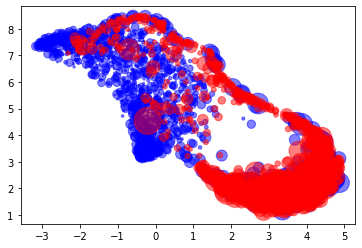

In [14]:
# with plt.style.context("dark_background"):
fig = metric_trainer.plot_embeddings(
    algorithm="UMAP",
    item_sizes=item_sizes,
    user_sizes=user_sizes,
    figure_args=dict(figsize=(15, 15)),
)
plt.savefig(f"images/{name}.png")
plt.show()

In [ ]:
full_hr = full_hit_rate(metric_trainer, valid_set, data_train)

row = ",".join(
    map(
        str,
        [
            name,
            model,
            cfg.embedding_dim,
            cfg.margin,
            cfg.lam,
            cfg.lr,
            metric_trainer.logs["valid_epoch_loss"][-1],
            int(metric_trainer.logs["valid_step_hits"][-1]),
            metric_trainer.logs["valid_epoch_hitrate"][-1],
            metric_trainer.logs["valid_epoch_ndcg"][-1],
            full_hr,
        ],
    )
)

with open("logs_test.txt", "a") as f:
    f.write(row)
    f.write("\n")

print(row)